# Map persistent and temporary water and vegetated wetlands
This notebook demonstrates how to load Landsat time series data, compute a Tasseled Cap Wetness index and identify persistent and temporary wet terrain using annual percentiles. It then demonstrates computing NDVI percentiles for areas of wet terrain to identify persistent or temporary vegetated wetlands.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
import glob
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map

from ga_utils import tasseled_cap

dc = datacube.Datacube(app = 'my_app')


## Set up analysis

In [2]:
# Define satellite data to import
platform = "LANDSAT_8"
product = "ls8_usgs_sr_scene"  # "ls8_lasrc_kenya"


In [3]:
# Singida, Tanzania
name='casamance_senegal'
frac_res = 1
longitude_extents = (-16.83, -16.28)
latitude_extents = (13.05, 12.4)
time_extents = ('2017-01-01', '2018-01-01')

# Marigot de Bignone
name='marigotdebignone'
product = "ls8_usgs_sr_scene" 
frac_res = 1.0
longitude_extents = (-16.57, -16.21)
latitude_extents = (12.83, 12.5)
time_extents = ('2017-01-01', '2018-01-01')

display_map(latitude_extents, longitude_extents)

## Import Landsat data and mask by cloud

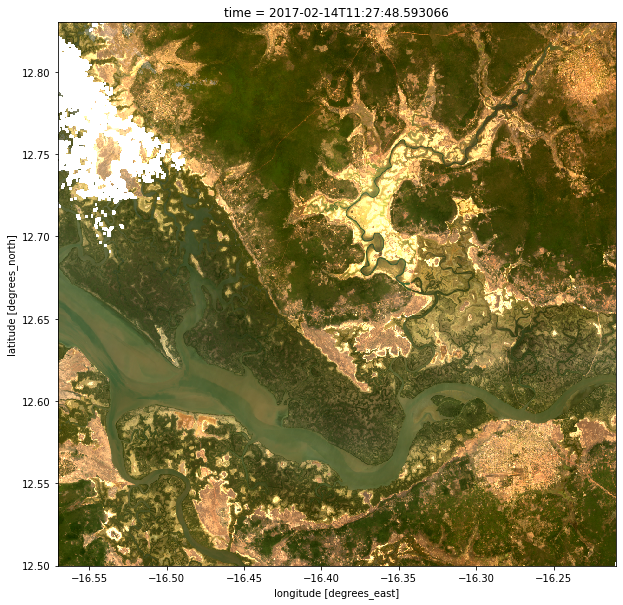

In [4]:
# Load in Landsat data for temporal and spatial extent and mask to remove cloud
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa'], 
                          time = time_extents,
                          output_crs = 'EPSG:4326', resolution = (-0.0003, 0.0003),
                          group_by = 'solar_day')

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

# Mask out cloudy pixels
landsat_dataset = landsat_dataset.where(cloud_mask)

# Plot single time step
landsat_dataset[['red', 'green', 'blue']].isel(time=5).to_array().plot.imshow(robust=True, size=10, aspect=1)

## Compute Tasseled Cap Indices for time series

In [5]:
tci_values = tasseled_cap(landsat_dataset, 
                          tc_bands=['greenness', 'brightness', 'wetness'],
                          drop=True)

### Calculate and compare wet terrain in the 10th, 50th and 90th percentiles of TCI wetness
The 10th percentile layer represents persistently wet terrain, the 50th percentile represents median conditions, and the 90th percentile represents temporarily wet terrain.

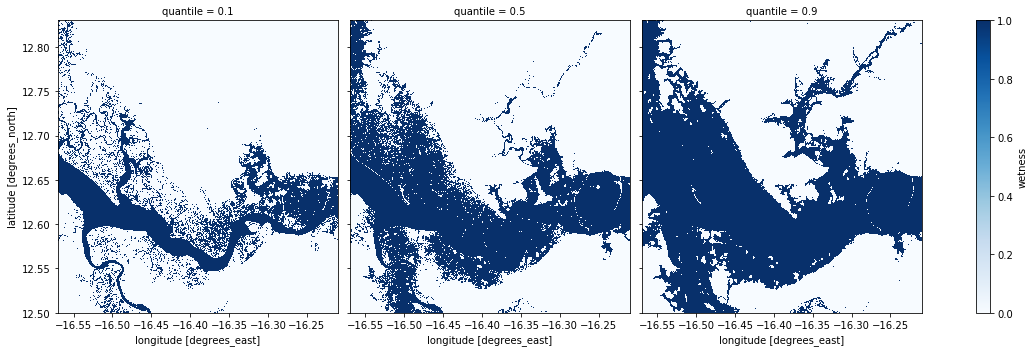

In [6]:
# Compute quantiles
tci_quantiles = tci_values.wetness.quantile(q=[0.1, 0.5, 0.9], dim='time')  

# Plot
wetness_threshold = -300
(tci_quantiles > wetness_threshold).plot(col='quantile', size=5, cmap='Blues')

### Plot as an RGB image
Plot as an RGB image where red = 10th percentile wet terrain, green = 50th percentile wet terrain, and blue = 90th percentile wet terrain. White indicates terrain that is wet across all percentiles.

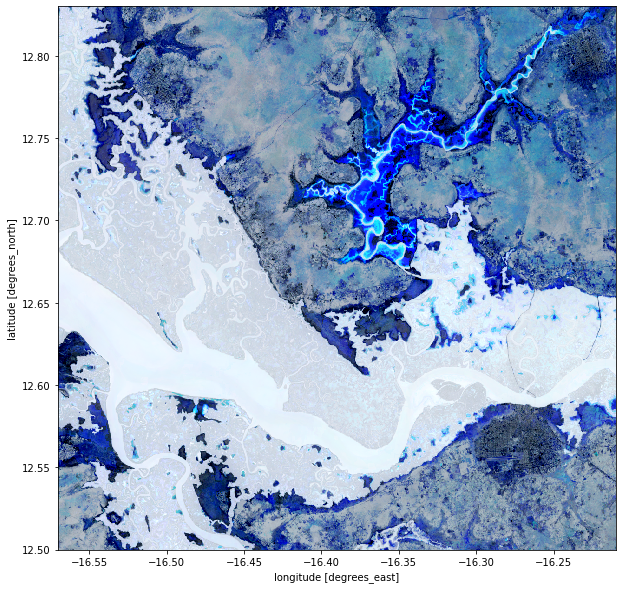

In [7]:
tci_quantiles.sel(quantile=[0.1, 0.5, 0.9]).plot.imshow(robust=True, size=10, aspect=1.0)

### Combine 10th and 90th percentiles into a single persistent and temporary wet terrain raster

In [8]:
# Create single categorical array giving location of permanent and tempory wet terrain
persistent_wet, median_wet, temp_wet = (tci_quantiles > wetness_threshold)   #.values.astype(int)
classification = xr.where(persistent_wet == 1, 2, temp_wet)
classification

<xarray.DataArray 'wetness' (latitude: 1101, longitude: 1201)>
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * latitude   (latitude) float64 12.83 12.83 12.83 12.83 ... 12.5 12.5 12.5
  * longitude  (longitude) float64 -16.57 -16.57 -16.57 ... -16.21 -16.21 -16.21

## Plot output categorised map

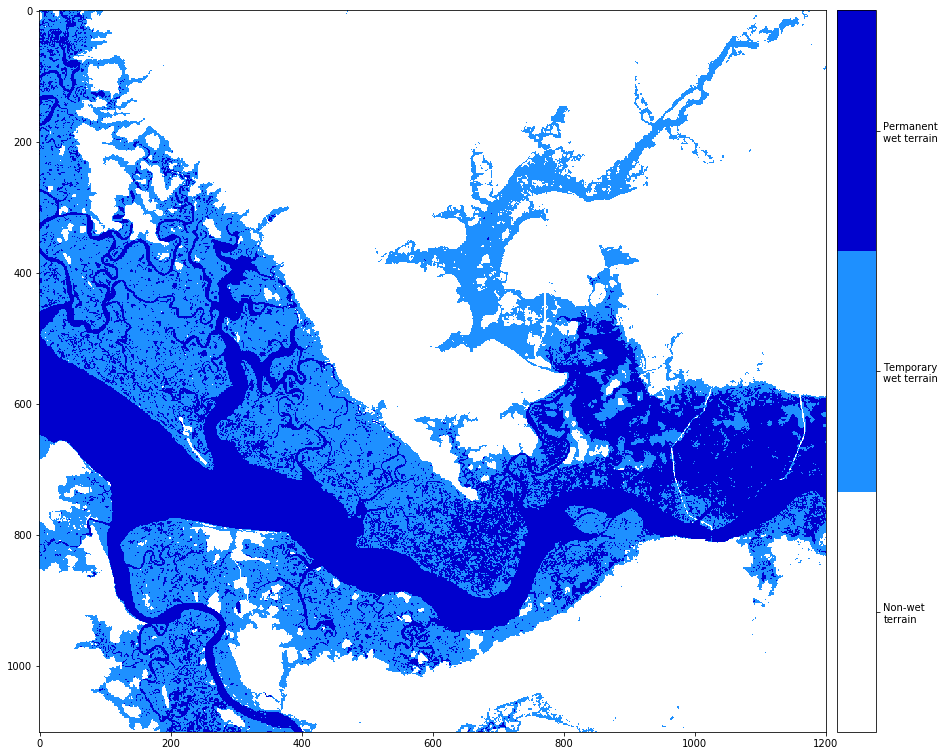

In [9]:
# Discrete/categorical colours
cmap = colors.ListedColormap(['white', 'dodgerblue', 'mediumblue'])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot array using new cmap
fig, ax = plt.subplots(figsize=(15, 15))
img = ax.imshow(classification.values, interpolation='nearest', 
                 cmap=cmap, norm=norm)

# Add legend with centered labels
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, 
                    ticks=[i + 0.5 for i in bounds[:-1]], cax = cax)
cbar.ax.set_yticklabels(['Non-wet\nterrain', 'Temporary\nwet terrain', 'Permanent\nwet terrain'])
plt.show()


## Compute NDVI to identify vegetated wetlands

In [10]:
landsat_dataset['ndvi'] = ((landsat_dataset.nir - landsat_dataset.red) / (landsat_dataset.nir + landsat_dataset.red))

In [11]:
# Compute quantiles for area located within wet categories from TCI
ndvi_quantiles = landsat_dataset.ndvi.where(classification > 0).quantile(q=[0.1, 0.9], dim='time')  

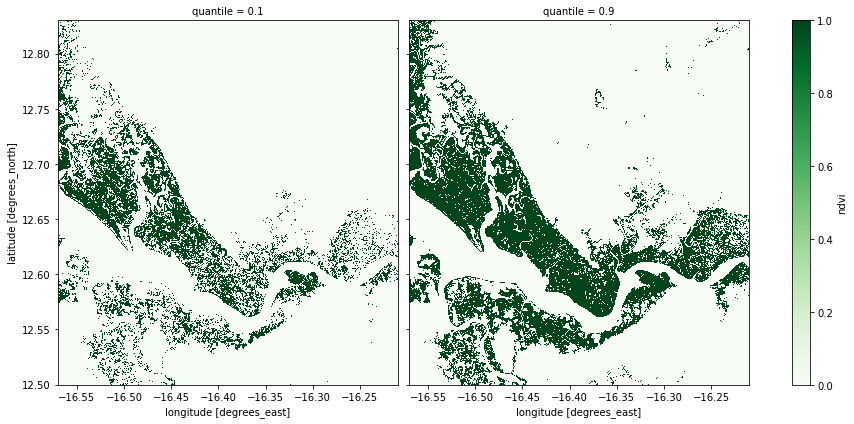

In [12]:
# Plot
ndvi_threshold = 0.3
(ndvi_quantiles > ndvi_threshold).plot(col='quantile', size=6, cmap='Greens')

In [13]:
persistent_veg, temp_veg = (ndvi_quantiles > ndvi_threshold)  
veg_classification = xr.where(persistent_veg == 1, 2, temp_veg)

In [14]:
landsat_dataset[['red', 'green', 'blue']].isel(time=5).to_array()

<xarray.DataArray (variable: 3, latitude: 1101, longitude: 1201)>
array([[[1258., 1184., ..., 1169., 1107.],
        [1215., 1260., ..., 1491., 1528.],
        ...,
        [ 508.,  514., ...,   nan,   nan],
        [ 530.,  512., ...,   nan,   nan]],

       [[1123., 1074., ...,  879.,  871.],
        [1096., 1124., ..., 1129., 1156.],
        ...,
        [ 591.,  601., ...,   nan,   nan],
        [ 593.,  610., ...,   nan,   nan]],

       [[ 750.,  692., ...,  596.,  567.],
        [ 715.,  749., ...,  780.,  714.],
        ...,
        [ 261.,  260., ...,   nan,   nan],
        [ 263.,  260., ...,   nan,   nan]]])
Coordinates:
    time       datetime64[ns] 2017-02-14T11:27:48.593066
  * longitude  (longitude) float64 -16.57 -16.57 -16.57 ... -16.21 -16.21 -16.21
  * latitude   (latitude) float64 12.83 12.83 12.83 12.83 ... 12.5 12.5 12.5
  * variable   (variable) <U5 'red' 'green' 'blue'
Attributes:
    crs:      EPSG:4326

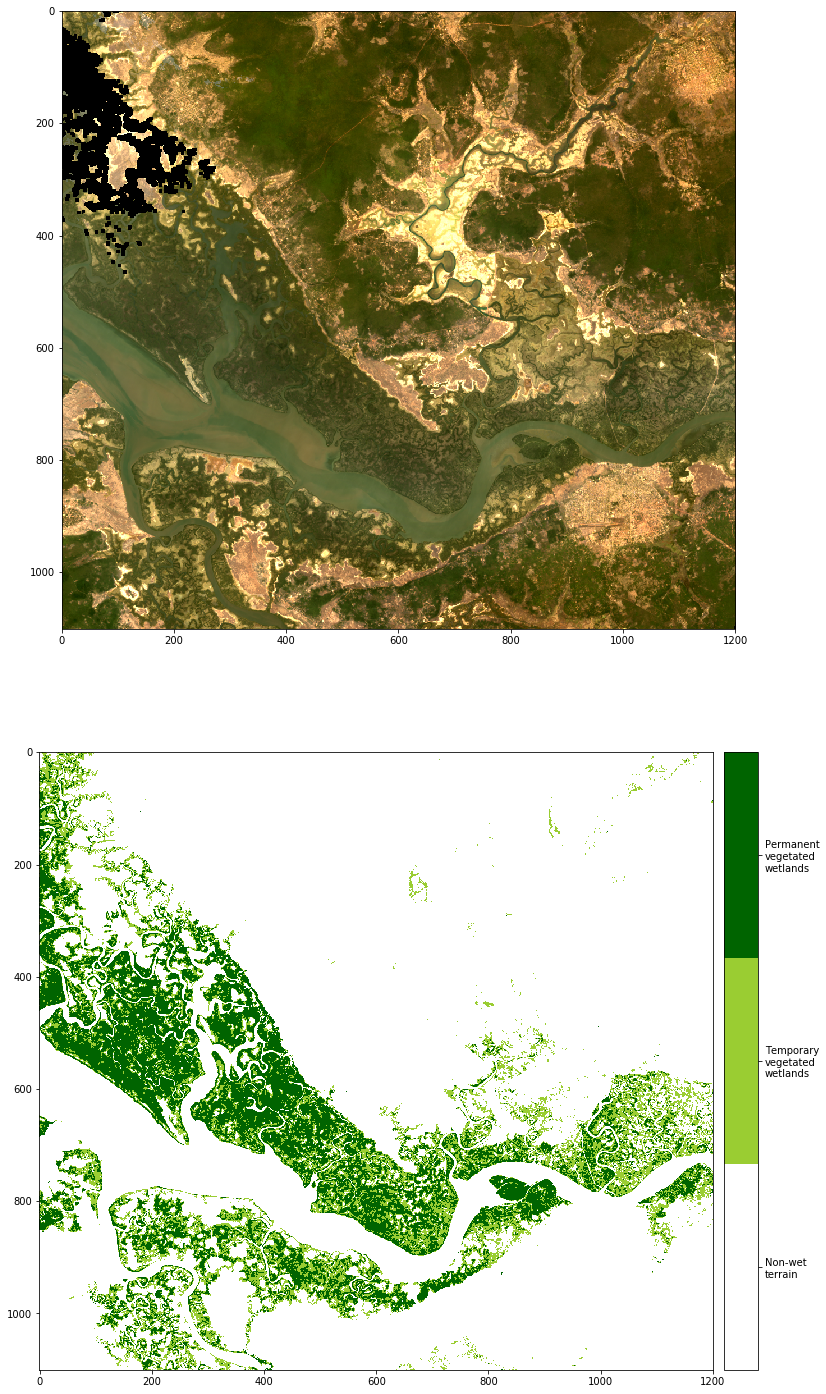

In [16]:
from skimage import exposure

# Discrete/categorical colours
cmap = colors.ListedColormap(['white', 'yellowgreen', 'darkgreen'])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot array using new cmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 25))

# # Plot RGB as raster after optimising colours using a percentile stretch
rgb_array = np.transpose(landsat_dataset[['red', 'green', 'blue']].isel(time=5).to_array().values, [1, 2, 0])
p_low, p_high = np.nanpercentile(rgb_array, [2, 98])
img_toshow = exposure.rescale_intensity(rgb_array, in_range=(p_low, p_high), out_range=(0, 1))
ax1.imshow(img_toshow)

# Plot vegetation class as raster
img = ax2.imshow(veg_classification.values, interpolation='nearest',
                cmap=cmap, norm=norm)

# Add legend with centered labels
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, 
                    ticks=[i + 0.5 for i in bounds[:-1]], cax = cax)
cbar.ax.set_yticklabels(['Non-wet\nterrain', 'Temporary\nvegetated\nwetlands', 'Permanent\nvegetated\nwetlands'])
plt.show()

## Export to geotiff file

In [17]:
xcols = len(landsat_dataset.longitude)
yrows = len(landsat_dataset.latitude)

import rasterio

kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.int16,
         'crs': 'EPSG:4326',
         'transform': landsat_dataset.geobox.transform,
         'nodata': 0}

with rasterio.open('GA_outputs/vegetated_wetlands.tif', 'w', **kwargs) as target:
    target.write_band(1, veg_classification.values.astype(rasterio.int16))